# imports

In [34]:
from PIL import Image
from glob import glob
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import numpy as np
import SimpleITK as sitk


# Load image

In [2]:

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

# List all available files to work with

In [3]:
luna_subset_path = '/Users/mostafa/Desktop/dsb_analyse/input/subset0/'
file_list=glob(luna_subset_path+"*.mhd")
file_list

['/Users/mostafa/Desktop/dsb_analyse/input/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd',
 '/Users/mostafa/Desktop/dsb_analyse/input/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd',
 '/Users/mostafa/Desktop/dsb_analyse/input/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238522526736091851696274044574.mhd',
 '/Users/mostafa/Desktop/dsb_analyse/input/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd',
 '/Users/mostafa/Desktop/dsb_analyse/input/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd',
 '/Users/mostafa/Desktop/dsb_analyse/input/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.mhd',
 '/Users/mostafa/Desktop/dsb_analyse/input/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd',
 '/Users/mostafa/Desktop/dsb_analyse/input/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd',
 '/Users/mostafa/Desktop

# A function to plot a ct scan from different slices

In [4]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

# Plot 3d

In [5]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

# Reshape all images to isomorphic shape

In [6]:
def resample(image, previous_spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array(previous_spacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

# I want to know are these values Hounsfield Units or not

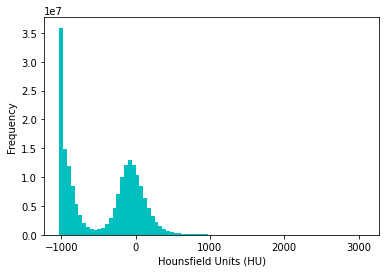

In [7]:
from matplotlib import pyplot as plt

img, origin, spacing = load_itk(file_list[0])
first_patient_pixels = img
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

So, They are in hounsfield unit shape.

Next I want to resample an image:

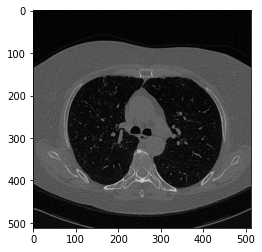

In [8]:
from matplotlib import pyplot as plt
plt.imshow(first_patient_pixels[505,:,:], cmap=plt.cm.gray)
plt.show()

In [9]:
img2, spacing2 = resample(img, spacing)

# Segment lungs and remove extra parts

In [10]:
def get_segmented_lungs(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    image label: 0
    '''
    plt_number = 0
    if plot:
        f, plots = plt.subplots(12, 1, figsize=(5, 40))
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    '''
    Step 1: Convert into a binary image. 
    image label: 1
    '''
    binary = im < -604
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    '''
    Step 2: Remove the blobs connected to the border of the image.
    image label: 2
    '''
    cleared = clear_border(binary)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(cleared, cmap=plt.cm.bone)
        plt_number += 1
    '''
    Step 3: Label the image.
    image label: 3
    '''
    label_image = label(cleared)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1

    '''
    Step 4: Keep the labels with 2 largest areas and segment two lungs.
    image label: 4
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    labels = []
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(label_image[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]
    # to remove big detected tissues which their area is less than 1 percent of whole image
    # to_remove_little_tissues = label_image > 0
    # if np.sum(to_remove_little_tissues) / (
    #         to_remove_little_tissues.shape[0] * to_remove_little_tissues.shape[1]) < 0.01:
    #     label_image = np.zeros((label_image.shape[0], label_image.shape[1]))
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
    '''
    Step 5: Fill in the small holes inside the mask of lungs which we seperate right and left lung. r and l are symbolic and they can be actually left and right!
    image labels: 5, 6
    '''
    r = label_image == labels[0]
    l = label_image == labels[1]
    r_edges = roberts(r)
    l_edges = roberts(l)
    r = ndi.binary_fill_holes(r_edges)
    l = ndi.binary_fill_holes(l_edges)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1

    '''
    Step 6: convex hull of each lung
    image labels: 7, 8
    '''
    r = convex_hull_image(r)
    l = convex_hull_image(l)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1
    '''
    Step 7: joint two separated right and left lungs.
    image label: 9
    '''
    sum_of_lr = r + l
    binary = sum_of_lr > 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    '''
    Step 8: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    image label: 10
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    '''
    Step 9: Superimpose the binary mask on the input image.
    image label: 11
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    return im


def segment_lung_from_ct_scan(image):
    return np.asarray([get_segmented_lungs(slicee) for slicee in image])

In [11]:
img3 = segment_lung_from_ct_scan(img2)

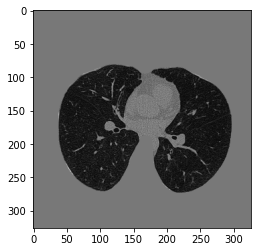

In [12]:
from matplotlib import pyplot as plt
plt.imshow(img3[200,:,:], cmap=plt.cm.gray)
plt.show()

Compared to first image which was:

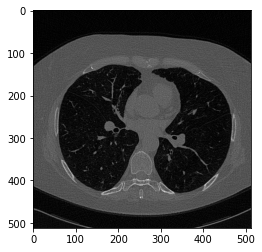

In [13]:
from matplotlib import pyplot as plt
plt.imshow(first_patient_pixels[400,:,:], cmap=plt.cm.gray)
plt.show()

In [14]:
MIN_BOUND = -1200.0
MAX_BOUND = 600.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image * 255

In [15]:
img4 = normalize(img3)

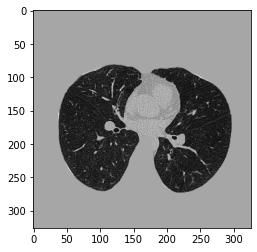

In [16]:
plt.imshow(img4[200,:,:], cmap=plt.cm.gray)
plt.show()

**Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures.**

In [17]:
PIXEL_MEAN = 0.25 * 256

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [18]:
img5 = zero_center(img4)

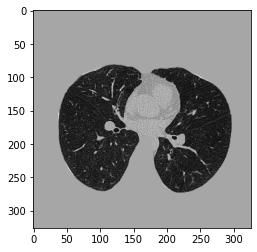

In [19]:
plt.imshow(img5[200,:,:], cmap=plt.cm.gray)
plt.show()

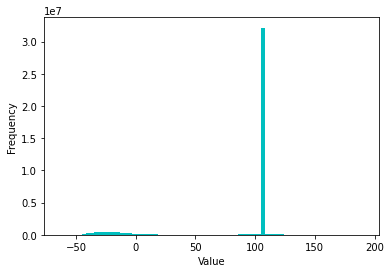

In [20]:
plt.hist(img5.flatten(), bins=80, color='c')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [21]:
annotations = pd.read_csv('/Users/mostafa/Desktop/dsb_analyse/input/annotations.csv')
candidates = pd.read_csv('/Users/mostafa/Desktop/dsb_analyse/input/candidates.csv')

In [22]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


But we have resampled the image, so we need a function to translate this coordinates

In [23]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


In [24]:
file_names = [f.split('/')[-1][:-4] for f in file_list]

In [25]:
filtered_candidates = candidates[candidates['seriesuid'].isin(file_names)]

In [26]:
filtered_candidates

,seriesuid,coordX,coordY,coordZ,class
9310,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,129.568151,45.377097,-277.835758,0
9311,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-97.260000,56.360000,-201.930000,0
9312,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,99.230491,-4.882165,-128.691305,0
9313,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-15.287525,-59.105100,-251.303750,0
9314,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,109.344666,1.891737,-237.284699,0
...,...,...,...,...,...
548682,1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...,-65.847500,102.866327,-144.628410,0
548683,1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...,104.980771,42.457062,-138.565904,0
548684,1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...,43.020099,67.261770,-147.857901,0
548685,1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...,-21.779917,73.436921,-73.874167,0


In [27]:
positive_rows = filtered_candidates[filtered_candidates['class']==1] 
negative_rows = filtered_candidates[filtered_candidates['class']==0]
positive_rows.head()

,seriesuid,coordX,coordY,coordZ,class
15647,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.460000,68.010000,-230.550000,1
16831,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.540000,78.100000,-122.920000,1
16978,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,44.250000,52.170000,-110.250000,1
17222,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.003141,47.665253,-108.482213,1
20044,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.310000,116.670000,-181.890000,1


In [28]:
print(positive_rows.count())
print(negative_rows.count())

seriesuid    122
coordX       122
coordY       122
coordZ       122
class        122
dtype: int64
seriesuid    56816
coordX       56816
coordY       56816
coordZ       56816
class        56816
dtype: int64


In [29]:
class CTScan(object):
    def __init__(self, filename=None, coords=None):
        self.filename = filename
        self.coords = coords
        path = '/Users/mostafa/Desktop/dsb_analyse/input/subset0/' + self.filename + '.mhd'
        self.ds = sitk.ReadImage(path)
        self.spacing = self.ds.GetSpacing()
        self.origin = self.ds.GetOrigin()
        self.image = sitk.GetArrayFromImage(self.ds)

    def reset_coords(self, coords):
        self.coords = coords

    def resample(self):
        image = self.image
        previous_spacing = self.spacing
        new_spacing = [1, 1, 1]
        spacing = np.array(previous_spacing, dtype=np.float32)
        resize_factor = spacing / new_spacing
        new_real_shape = image.shape * resize_factor
        new_shape = np.round(new_real_shape)
        real_resize_factor = new_shape / image.shape
        new_spacing = spacing / real_resize_factor
        image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
        self.image = image
        self.spacing = new_spacing

    def segment_lung_from_ct_scan(self):
        self.image = np.asarray([get_segmented_lungs(slicee) for slicee in self.image])

    def transform(self):
        self.resample()
        self.segment_lung_from_ct_scan()
        self.normalize()
        self.zero_center()

    def get_world_to_voxel_coords(self, idx):
        return self.world_to_voxel(self.coords[idx])

    def world_to_voxel(self, worldCoord):
        stretchedVoxelCoord = np.absolute(worldCoord - self.origin)
        voxelCoord = stretchedVoxelCoord / self.spacing
        return voxelCoord

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        voxel_coords = [self.get_world_to_voxel_coords(j) for j in range(len(self.coords))]
        return tuple(voxel_coords)

    def get_image(self):
        return self.image

    def get_subimage(self, width):
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y - width / 2:y + width / 2, x - width / 2:x + width / 2]
        return subImage

    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray > 1] = 1.
        npzarray[npzarray < 0] = 0.
        return npzarray

    def normalize(self):
        MIN_BOUND = -1200
        MAX_BOUND = 600.
        self.image = (self.image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        self.image[self.image > 1] = 1.
        self.image[self.image < 0] = 0.
        self.image *= 255.

    def zero_center(self):
        PIXEL_MEAN = 0.25 * 256
        self.image = self.image - PIXEL_MEAN

    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image * 255).convert('L').save(filename)


In [30]:
ct = CTScan(filename='1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410')

In [31]:
ct.transform()

In [32]:
ct.image.shape


(467, 326, 256)

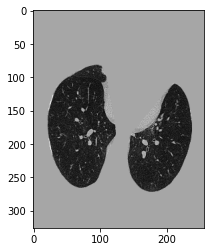

In [33]:
from matplotlib import pyplot as plt
plt.imshow(ct.image[199,:,:], cmap=plt.cm.gray)
plt.show()